In [1]:
from utils import render
import glob
import trimesh
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

## Compute Metrics

In [2]:
models = ["dmc", "onet", "psgn", "r2n2", "shapeflow"]
sid = ["02691156", "02958343", "03001627"]
root = "/home/maxjiang/data0/occupancy_networks/out/pointcloud"

dfs = []
for m in models:
    for s in sid:
        csv_name = f"{root}/{m}_{s}/generation/eval_meshes.csv"
        suffix = 'pcl' if m == 'psgn' else 'mesh'
        df = pd.read_csv(csv_name)
        df = df.loc[:, ['class name', f'chamfer-L1 ({suffix})', f'iou ({suffix})', f'normals ({suffix})']].copy()
        df.columns = ['class_name', 'chamfer_l1', 'iou', 'normals']
        df = df.assign(model=m, sid=s)
        dfs.append(df)
        
df = pd.concat(dfs)
df.loc[:, 'chamfer_l1'] = df['chamfer_l1'] * 10
df = df.pivot(index='class_name', columns='model', values=['chamfer_l1', 'iou', 'normals'])
df.loc['mean', :] = df.mean(axis=0).values
df

/home/maxjiang/software/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


chamfer_l1                                \
model                                       dmc      onet      psgn      r2n2   
class_name                                                                      
airplane,aeroplane,plane               0.096946  0.071138  0.097632  0.152472   
car,auto,automobile,machine,motorcar   0.172930  0.121796  0.129449  0.194949   
chair                                  0.128405  0.130227  0.175572  0.185072   
mean                                   0.132760  0.107721  0.134218  0.177497   

                                                     iou                 \
model                                shapeflow       dmc      onet psgn   
class_name                                                                
airplane,aeroplane,plane              0.085828  0.576205  0.715779  NaN   
car,auto,automobile,machine,motorcar  0.138840  0.718209  0.802895  NaN   
chair                                 0.188759  0.624960  0.651334  NaN   
mean                                  0.137809  0.639791  0.723336  NaN   

                                                           normals            \
model                                     r2n2 shapeflow       dmc      onet   
class_name                                                                     
airplane,aeroplane,plane              0.445327  0.615638  0.813407  0.885742   
car,auto,automobile,machine,motorcar  0.672832  0.664390  0.822227  0.864698   
chair                                 0.516589  0.439048  0.834765  0.859297   
mean                                  0.544916  0.573026  0.823466  0.869912   

                                                               
model                                psgn      r2n2 shapeflow  
class_name                                                     
airplane,aeroplane,plane              NaN  0.654624  0.838722  
car,auto,automobile,machine,motorcar  NaN  0.697932  0.768980  
chair                                 NaN  0.659908  0.764729  
mean                                  NaN  0.670821  0.790810

## Visualize Results

12


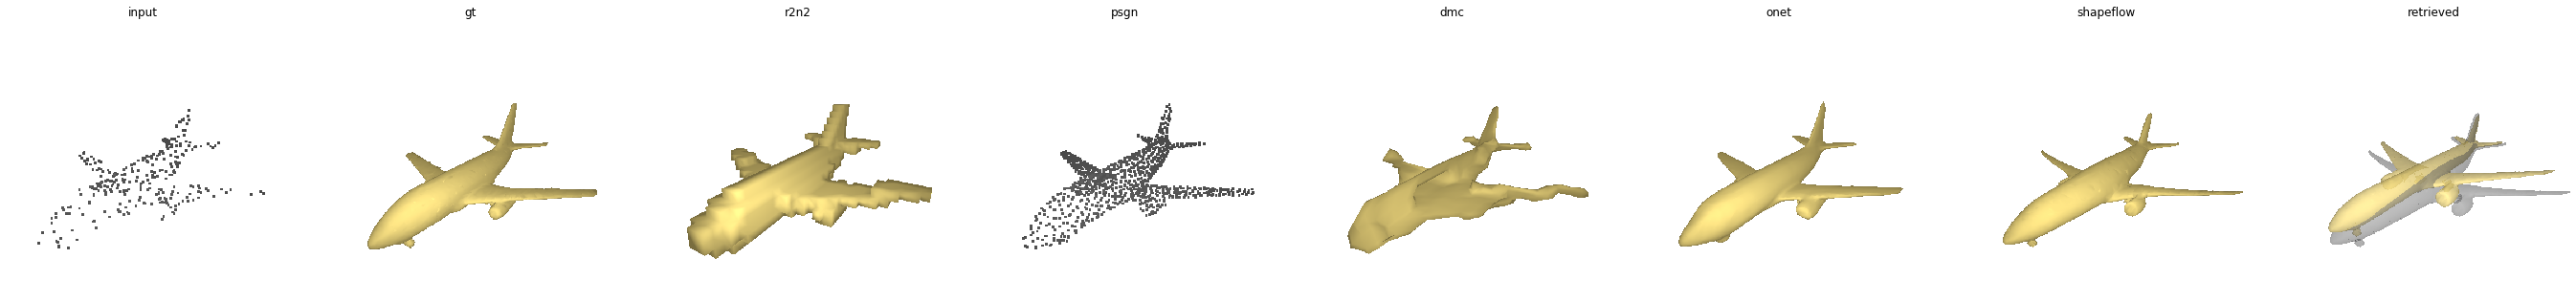

In [48]:
sid = "02691156" # 02958343 (1) # 02691156 (2), 02958343, 03001627 (62)
for shape_id in range(12, 13):
    print(shape_id)
    # rendering viewpoint
    eye_1 = [.8, .3, -.5]
    eye_2 = [.4, .4, .9]
    center = [0, 0, 0]
    up = [0, 1, 0]

    input_pcs = f"{root}/dmc_{sid}/generation/input/{sid}/*.ply"
    input_pcs = glob.glob(input_pcs)
    mesh_names = [os.path.basename(f).replace(".ply", "") for f in input_pcs]

    input_pc = input_pcs[shape_id]
    mesh_name = mesh_names[shape_id]
    gt_mesh = f"/home/maxjiang/codes/DeepDeform/data/shapenet_simplified/test/{sid}/{mesh_name}/model.ply"
    ret_mesh = f"/home/maxjiang/codes/DeepDeform/out/meta/{sid}/{mesh_name}/original_retrieved/0.ply"

    items = ["input", "gt", "r2n2", "psgn", "dmc", "onet", "shapeflow"]
    mesh_files = [input_pc, gt_mesh] + [f"{root}/{m}_{sid}/generation/{'pointcloud' if m == 'psgn' else 'meshes'}/{sid}/{mesh_name}.{'ply' if m == 'psgn' else 'off'}" for m in items[2:]]
    items += ["retrieved"]
    mesh_files += [ret_mesh]
    meshes = [trimesh.load(m) for m in mesh_files]
    meshes[0].colors = np.array([0.2, 0.2, 0.2])
    meshes[3].colors = np.array([0.2, 0.2, 0.2])
    imgs = []
    
#     meshes[-2] = [meshes[1].copy(), meshes[-2].copy()]
    meshes[-1] = [meshes[-2].copy(), meshes[-1].copy()]
#     meshes[-2][0].visual.vertex_colors = np.array([.2, .2, .2, .3])
    meshes[-1][0].visual.vertex_colors = np.array([.2, .2, .2, .5])
    meshes[-1][1].visual.vertex_colors = np.array([245, 195, 59, 255*0.8]) / 255.

    fig, axes = plt.subplots(figsize=(48,6), ncols=8, nrows=1)
    for i, (item, mesh) in enumerate(zip(items, meshes)):
        if isinstance(mesh, trimesh.PointCloud):
            kwargs = {"point_size": 5}
        elif isinstance(mesh, trimesh.Trimesh):
            kwargs = {}
            mesh.visual.vertex_colors = np.array([245, 195, 59]) / 255.
        img, _, _, _ = render.render_trimesh(mesh, eye_1, center, up, res=(512, 512), light_intensity=3, **kwargs)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(item)
        imgs.append(img)
    plt.show()    

In [49]:
# save images for paper
idx = 2
for img, item in zip(imgs, items):
    im = Image.fromarray(img)
    im.save(f"paper_figures/shapegen/{idx}_{item}.jpeg")